# Один в поле не воин: методы ансамблирования в машинном обучении 
# Открытый урок в рамках курса ML Professional

**Ссылка на курс:** 
https://otus.ru/lessons/machinelearning/

 **Старт** 28 марта

  **Расписание** Вторник, четверг, 20.00



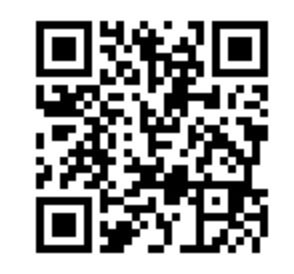

In [ ]:
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.datasets import fetch_california_housing
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz
import pydotplus

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")


# Increase viewable area of Pandas tables, numpy arrays, plots
#pd.set_option('max_rows', 15, 'max_columns', 500, 'max_colwidth', 1, 'precision', 2)
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)
sns.set()
plt.rcParams['figure.figsize'] = [16, 6]

# 1. Ансамбли

### Data  - Titanic data set

Сегодня мы будем работать с [данными ](https://www.kaggle.com/c/titanic/data) о пассажирах Титаника.

    VARIABLE DESCRIPTIONS:
    survival        Survival
                (0 = No; 1 = Yes)
    pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
    name            Name
    sex             Sex
    age             Age
    sibsp           Number of Siblings/Spouses Aboard
    parch           Number of Parents/Children Aboard
    ticket          Ticket Number
    fare            Passenger Fare
    cabin           Cabin
    embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

    SPECIAL NOTES:
    Pclass is a proxy for socio-economic status (SES)
     1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

    Age is in Years; Fractional if Age less than One (1)
     If the Age is Estimated, it is in the form xx.5

Загрузим данные.

In [ ]:
#data = pd.read_csv('titanic.csv')
data = pd.read_csv('https://grantmlong.com/data/titanic.csv')
cols_2_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name']
data = data.drop(cols_2_drop, axis=1)
data.loc[:, 'Age'] = data.Age.fillna(-999)

data = data.dropna()
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


# Базовый анализ данных (Exploratory Data Analysis)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


Пропусков в данных нет, но есть 2 категориальных признака (`Sex`,`Embarked`). Закодируем их с помощью `OrdinalEncoder`.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
data[['Sex','Embarked']] = enc.fit_transform(data[['Sex','Embarked']])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1.0,22.0,1,0,7.2500,2.0
1,1,1,0.0,38.0,1,0,71.2833,0.0
2,1,3,0.0,26.0,0,0,7.9250,2.0
3,1,1,0.0,35.0,1,0,53.1000,2.0
4,0,3,1.0,35.0,0,0,8.0500,2.0


In [ ]:
X = data.drop('Survived', axis=1)
Y = data['Survived']
#Train test split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=2)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((711, 7), (178, 7), (711,), (178,))

## Bagging
Вместо того, чтобы обучить одно дерево решений, обучим ансамбль по следующему алгоритму:

1. Сгенерируем $B$ бутсрэп выборок (сэмплирование с возвращением, помните?) из обучающего набора данных.
2. Обучим $B$ решающих деревьев $f_1, f_2, \dots, f_B$ на каждой из бутсреп подвыборок.
3. В качестве предсказания на тестовых данных возьмем среднее предсказание алгорима $\hat{y} = 1/B \sum_{i=0}^{B} f_i(x)$ (для задачи классификации возьмем наиболее популярный класс).


In [ ]:
# BaggingRegressor can be used with any model, not only decision trees

model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1, n_estimators=100)
model.fit(train_X, train_Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                  n_estimators=100, n_jobs=-1)

In [ ]:
print(f'Bagged trees accuracy score {accuracy_score(model.predict(test_X), test_Y):.4f}')


Bagged trees accuracy score 0.8034


Можем посмотреть на отдельные деревья.

In [ ]:
def plot_tree(model, X, fname='temp_tree.png'):
    dot_data = export_graphviz(model, filled=True, rounded=True, feature_names=X.columns, out_file=None)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(fname)
    img = plt.imread(fname)
    plt.imshow(img)

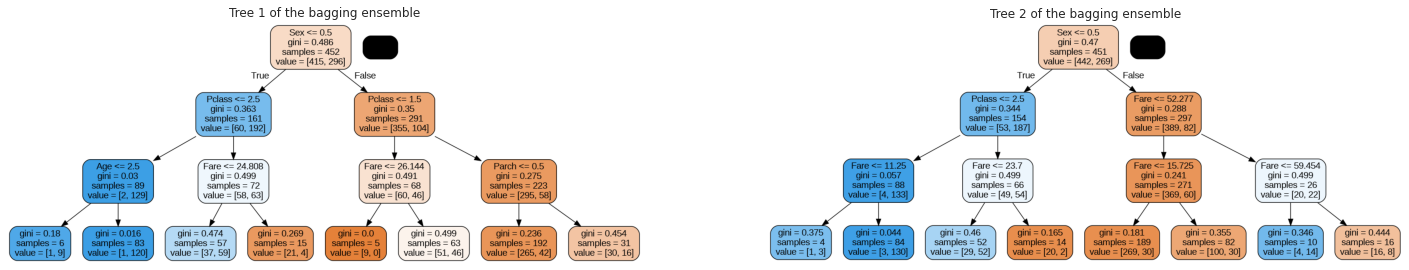

In [ ]:
tree1, tree2 = model.estimators_[0], model.estimators_[1]

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis('off')
plt.title(f'Tree 1 of the bagging ensemble')
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X)
plt.axis('off')
plt.title(f'Tree 2 of the bagging ensemble')
plt.show()

## Random Forests
Деревья в бэггинг ансамблях зачастую сильно **коррелируют** между собой. Они очень похожи, так как обучаются на похожих выборках. Когда мы агрегируем предсказания похожих деревьев, мы не так сильно уменьшаем разброс (variance), как нам бы хотелось.

Как уменьшить корреляцию деревьев?

**Solution: Random Forest!** Построим ансамбль деревьев определенным образом. Каждый раз, когда будем выбирать сплит при обучении, будем перебирать только $m$ случайно выбранных признаков из $p$, при этом $m < p$.

In [ ]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 3, oob_score=True)
model.fit(train_X, train_Y)

RandomForestClassifier(max_depth=3, n_jobs=-1, oob_score=True)

In [ ]:
#print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')

Actual test score: 0.8258


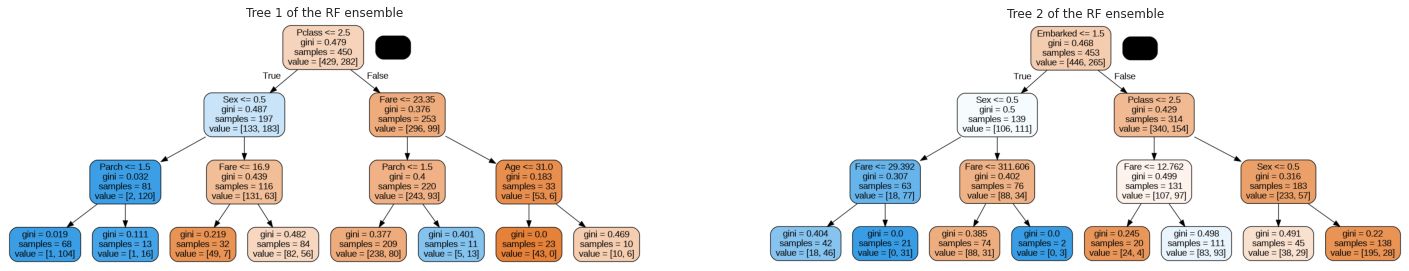

In [ ]:
tree1, tree2 = model.estimators_[2], model.estimators_[1]

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis('off')
plt.title(f'Tree 1 of the RF ensemble')
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X)
plt.axis('off')
plt.title(f'Tree 2 of the RF ensemble')
plt.show()

In [ ]:
# Now lets try realistic max_depth
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth = None, oob_score=True)
model.fit(train_X, train_Y)
#print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')


Actual test score: 0.8034


Кроме регрессии и классификации random forest используется для:
* Кластеризации 
* Детекции аномалий
* Отбора признаков

и не только!

# Градиентный бустинг
## Алгоритм

Хорошее [объяснение алгоритма](https://habr.com/ru/company/ods/blog/327250/).

* Применение дерева решений на данных
* Вычисление погрешности ошибок. Фактическое целевое значение, минус прогнозируемое целевое значение 

$$e_1 = y — y\_pred_1$$
* Установка новой модели для отклонений в качестве целевой переменной с одинаковыми входными переменными 
$$y_2\_pred$$
где $y_2\_pred$ - предсказания для погрешности ошибки с предыдущего шага - $e_1$
* Добавление предсказанных отклонений к предыдущим прогнозам $y\_pred\_total = y\_pred_1 + y_2\_pred$
* Установка еще одной модели оставшихся отклонений $e_2 = y — y\_pred\_total$

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 200

est = GradientBoostingClassifier(n_estimators=200, max_depth=3)
est.fit(train_X, train_Y)
pred = est.predict(test_X)

print('Test score: ', round(accuracy_score(pred, test_Y),3))

Test score:  0.826


### Хотите узнать больше крутых алгоритмов машинного обучения?

### Тогда ждем вас на курсе ML-Professional: https://otus.ru/lessons/machinelearning/ 

### Начало уже 28 марта!